In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm


%matplotlib inline 

The primary point of this notebook is to see what changes at the end now that the dataset is much larger. For the detailed EDA analysis see Spicata_EDA. What we see here for the final graphs around performing basic linear interpolation is that the results from the original EDA are generally confirmed.

In [2]:
df_sp = pd.read_csv("../../data/spicata_clean_500.csv")
df_sp.head()

C:\Users\lisa_\AppData\Local\Temp\ipykernel_60988\4074931185.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df_sp = pd.read_csv("../../data/spicata_clean_500.csv")


,Unnamed: 0,id,observed_on_string,observed_on,time_observed_at,time_zone,user_id,created_at,quality_grade,url,...,species_guess,scientific_name,common_name,taxon_kingdom_name,taxon_genus_name,taxon_species_name,geoprivacy_obscured,taxon_geoprivacy_obscured,minute_diff,km_diff
0,0,156253,1990-09-01 20:20:16,1990-09-01,1990-09-02 00:20:16+00:00,Eastern Time (US & Canada),317,2012-12-03 02:52:30+00:00,research,http://www.inaturalist.org/observations/156253,...,Cururu Toad,Rhinella diptycha,Cururu Toad,Animalia,Rhinella,Rhinella diptycha,0,0,-1.000000e-03,-0.001000
1,1,99704839,Fri May 20 1994 09:37:00 GMT-0400 (EDT),1994-05-20,1994-05-20 13:37:00+00:00,Eastern Time (US & Canada),317,2021-10-29 13:45:37+00:00,research,https://www.inaturalist.org/observations/99704839,...,Brown-headed Cowbird,Molothrus ater,Brown-headed Cowbird,Animalia,Molothrus,Molothrus ater,0,0,1.953437e+06,7492.228775
2,2,99705133,Fri May 20 1994 09:37:00 GMT-0400 (EDT),1994-05-20,1994-05-20 13:37:00+00:00,Eastern Time (US & Canada),317,2021-10-29 13:49:59+00:00,research,https://www.inaturalist.org/observations/99705133,...,Northern Cardinal,Cardinalis cardinalis,Northern Cardinal,Animalia,Cardinalis,Cardinalis cardinalis,0,0,0.000000e+00,0.000000
3,3,160735,Thu May 20 1994 15:27:35 GMT-0400 (EDT),1994-05-20,1994-05-20 19:27:35+00:00,Eastern Time (US & Canada),317,2012-12-11 20:23:37+00:00,research,http://www.inaturalist.org/observations/160735,...,Brown-headed Cowbird,Molothrus ater,Brown-headed Cowbird,Animalia,Molothrus,Molothrus ater,0,0,3.505833e+02,0.472500
4,4,36335283,Wed Jul 28 1999 08:24:34 GMT-0400 (EDT),1999-07-28,1999-07-28 12:24:34+00:00,Eastern Time (US & Canada),317,2019-12-04 01:50:03+00:00,research,https://www.inaturalist.org/observations/36335283,...,American Red Squirrel,Tamiasciurus hudsonicus,American Red Squirrel,Animalia,Tamiasciurus,Tamiasciurus hudsonicus,0,0,2.728377e+06,56.747939


# Quick Touchup
Even though the dataset was cleaned in the Spicata_Clean_and_Prep notebook, there are a few things to tweak due to how it  saved as a csv in the previous notebook.

In [3]:
# when I saved to csv, it encoded the index as it's own column--need to drop
df_sp.drop("Unnamed: 0", axis = 1, inplace = True)


In [4]:
df_sp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050151 entries, 0 to 1050150
Data columns (total 29 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   id                                1050151 non-null  int64  
 1   observed_on_string                1050151 non-null  object 
 2   observed_on                       1050151 non-null  object 
 3   time_observed_at                  1050151 non-null  object 
 4   time_zone                         1050151 non-null  object 
 5   user_id                           1050151 non-null  int64  
 6   created_at                        1050151 non-null  object 
 7   quality_grade                     1050151 non-null  object 
 8   url                               1050151 non-null  object 
 9   image_url                         1045138 non-null  object 
 10  sound_url                         3684 non-null     object 
 11  num_identification_agreements     105

In [5]:
# convert time objects to UTC datetimes
df_sp["time_observed_at"] = pd.to_datetime(df_sp["time_observed_at"], utc = True)
df_sp["created_at"] = pd.to_datetime(df_sp["created_at"], utc = True)

# Timestamps
How does the "time_observed_at" date relate to or diverge from "time_created_at"? \
[A brief history of iNaturalist is given here for context.](https://www.inaturalist.org/pages/about#:~:text=iNaturalist.org%20began%20as%20the,School%20of%20Information%20in%202008.)

In [6]:
# What is the range of times for both columns?
print(f'Earliest observation date: {df_sp["time_observed_at"].min()};\n\
Last observation date: {df_sp["time_observed_at"].max()}')
print(f'Earliest observation created at: {df_sp["created_at"].min()}; \n\
Last observation created at: {df_sp["created_at"].max()}')

Earliest observation date: 1944-08-12 22:58:00+00:00;
Last observation date: 2024-01-05 22:35:56+00:00
Earliest observation created at: 2010-11-01 04:04:18+00:00; 
Last observation created at: 2024-01-06 19:36:21+00:00


Suggested code for time efficient way of grouping datetimes by year used below was in [this Stackoverview thread.](https://stackoverflow.com/questions/11391969/how-to-group-pandas-dataframe-entries-by-date-in-a-non-unique-column)

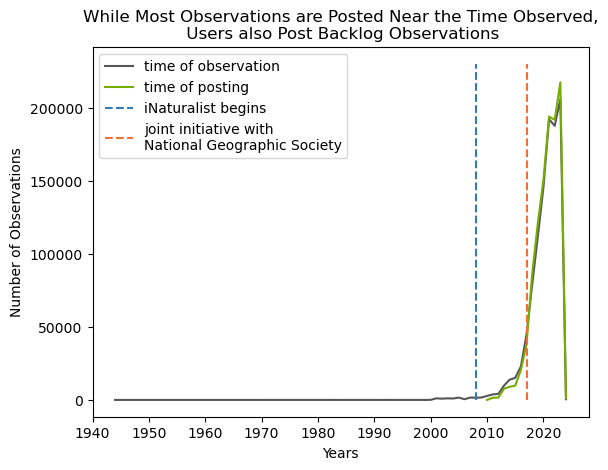

In [7]:
#Visualizing count of posts over the years for both time columns

# creating a count of entries by year groupings based on time_observed_at and time created_at
obs_time_by_year = df_sp.groupby(df_sp["time_observed_at"].map(lambda x: x.year))["id"].count()
created_time_by_year = df_sp.groupby(df_sp["created_at"].map(lambda x: x.year))["id"].count()

#plotting the two to compare
plt.figure()
#a line plot for each column
plt.plot(obs_time_by_year.index, obs_time_by_year.values, label = "time of observation", color = '#565656' )
plt.plot(created_time_by_year.index, created_time_by_year.values, label = "time of posting", color = '#74ac00')
#vertical lines to show important dates for iNaturalist
plt.vlines(2008, 0, 230000, color = '#337AB7' , label = "iNaturalist begins", linestyle = "dashed")
plt.vlines(2017, 0, 230000, color = '#f16f3a' , label = "joint initiative with \nNational Geographic Society", linestyle = "dashed")
plt.legend()
plt.xlabel("Years")
plt.ylabel("Number of Observations")
plt.title("While Most Observations are Posted Near the Time Observed,\n Users also Post Backlog Observations")
plt.show()


In [8]:
# How many observations predate earliest "created_at" time?
(df_sp["time_observed_at"]<df_sp["created_at"].min()).sum()

13401

In [9]:
# How many users have observations predating earliest "created_at" time?
df_sp[df_sp["time_observed_at"]<df_sp["created_at"].min()]["user_id"].nunique()

50

In [10]:
# How many observations predate iNaturalist existing?
(df_sp["time_observed_at"]<'2008-01-01').sum()

7756

In [11]:
# How many users have observations predating iNaturalist existing?
df_sp[df_sp["time_observed_at"]<'2008-01-01']["user_id"].nunique()

39

In [12]:
# How many posts did each of these users with early observations have 
# that predate the first "created_at" date of the set?
early_posters = df_sp[df_sp["time_observed_at"]<'2008-01-01']["user_id"].unique() # set of users with early posts

for user in early_posters:
    early_obs = df_sp[(df_sp["user_id"] == user)  
                      & (df_sp["time_observed_at"]<df_sp["created_at"].min())].shape[0]
   

In [13]:
# How many posts did each of these users with early observations have
# that predate iNaturalist existing?

for user in early_posters:  
    even_earlier_obs = df_sp[(df_sp["user_id"] == user) \
                      & (df_sp["time_observed_at"]< '2008-01-01')].shape[0] 
    

In [14]:
# When did these users with early observations first begin posting on iNaturalist?

for user in early_posters:
    first_post = df_sp[df_sp["user_id"] == user]["created_at"].min()
   

In [15]:
# What percent of observations were posted more than d number of days after the observation was made?

percent_by_time_gap_in_days = {} #create dictionary holding d and the related percent

for d in range(0,366): # one year's worth of numbers
    #converts time difference to days and sums number of posts less than or equal to d
    num_posts = ((df_sp["created_at"] - df_sp["time_observed_at"]).dt.total_seconds() / (24 * 3600) <= d).sum() 
    percent = round(100 * num_posts / df_sp.shape[0],1) #converts to percent
    percent_by_time_gap_in_days[d] = percent # stores in dictionary
    
days_after_obs = [1, 2, 3, 5, 10, 20, 30, 50, 100, 200, 365] # print out specific data points
for d in days_after_obs:
    print(f'{percent_by_time_gap_in_days[d]}% of observations are posted within {d} day(s) after the observation was made.')

57.7% of observations are posted within 1 day(s) after the observation was made.
67.0% of observations are posted within 2 day(s) after the observation was made.
71.8% of observations are posted within 3 day(s) after the observation was made.
76.8% of observations are posted within 5 day(s) after the observation was made.
82.7% of observations are posted within 10 day(s) after the observation was made.
87.4% of observations are posted within 20 day(s) after the observation was made.
88.9% of observations are posted within 30 day(s) after the observation was made.
90.2% of observations are posted within 50 day(s) after the observation was made.
91.7% of observations are posted within 100 day(s) after the observation was made.
93.2% of observations are posted within 200 day(s) after the observation was made.
94.5% of observations are posted within 365 day(s) after the observation was made.


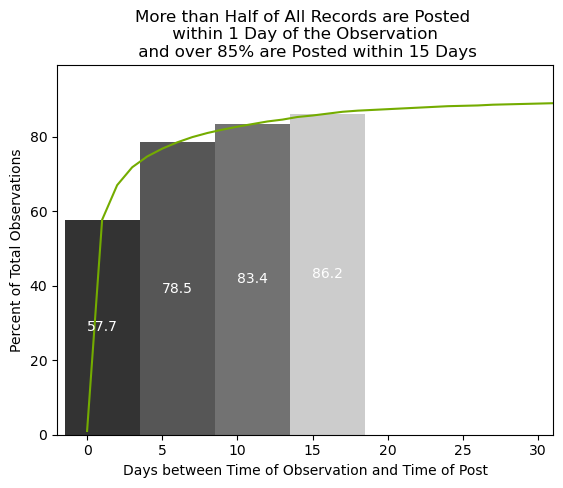

In [16]:
# Visualize the information above

time_gaps_to_highlight = [1, 6, 11, 16] # choose initial time gaps to highlight for x
percent_to_highlight = [percent_by_time_gap_in_days[i] for i in time_gaps_to_highlight] #corresponding y-values

plt.figure()
# line plot using smoother range of data from data dictionary above that stored all values 0 - 365 
plt.plot(list(percent_by_time_gap_in_days.keys()),
         list(percent_by_time_gap_in_days.values()),
         color = '#74ac00' )
plt.xlim(xmin = -2, xmax = 31) # limiting x-axis because asymptote occurs close to 95%

# to give the line plot some more readable substance, showing bars for "time_gaps_to_highlight"
b = plt.bar(time_gaps_to_highlight, 
        percent_to_highlight, 
        color = ['#333333', '#565656', '#727272', '#CCCCCC'],
        width = 5)
plt.bar_label(b, label_type = "center", color = 'white')

plt.xlabel("Days between Time of Observation and Time of Post")
plt.ylabel("Percent of Total Observations")
plt.title("More than Half of All Records are Posted \n \
within 1 Day of the Observation \n and over 85% are Posted within 15 Days")
plt.show()


# Numerical Summary

In [17]:
# summary of min_diff when -0.001 is removed 
min_diff_for_analysis = df_sp[(df_sp["minute_diff"]>=0)]["minute_diff"]
round(min_diff_for_analysis.describe(),3)

count    1.049851e+06
mean     1.183782e+03
std      5.387899e+04
min      0.000000e+00
25%      1.000000e+00
50%      3.000000e+00
75%      1.635000e+01
max      3.626322e+07
Name: minute_diff, dtype: float64

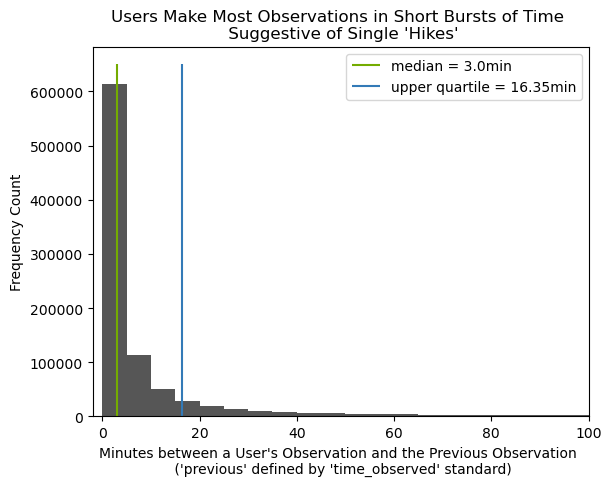

In [18]:
#What is the spread of the min_diff data?

#cutting off visual data after 100 minutes to see the most important parts of the shape rather than long tail
min_diff_visual = df_sp[(df_sp["minute_diff"]>=0)&(df_sp["minute_diff"]<=100)]["minute_diff"]
# median and upper quartile to include in visual
median = round(min_diff_for_analysis.median(),2)
upper_quartile = round(min_diff_for_analysis.describe()[6],2)

plt.figure()
plt.hist(min_diff_visual, color = '#565656', bins = 20)
plt.vlines(median, 0, 650000, color ='#74ac00', label = f'median = {median}min')
plt.vlines(upper_quartile, 0, 650000, color = '#337AB7', label = f'upper quartile = {upper_quartile}min')
plt.legend()
plt.xlim(xmin = -2, xmax = 100)
plt.xlabel("Minutes between a User's Observation and the Previous Observation \n ('previous' defined by 'time_observed' standard)")
plt.ylabel("Frequency Count")
plt.title("Users Make Most Observations in Short Bursts of Time \n Suggestive of Single 'Hikes'")
plt.show()

In [19]:
# summary of km_diff when -0.001 is removed and converted to meters

meters_diff_for_analysis = df_sp[df_sp["km_diff"]>=0]["km_diff"]*1000
round(meters_diff_for_analysis.describe(),0)

count     1049851.0
mean        19096.0
std        247867.0
min             0.0
25%             3.0
50%            43.0
75%           599.0
max      19991925.0
Name: km_diff, dtype: float64

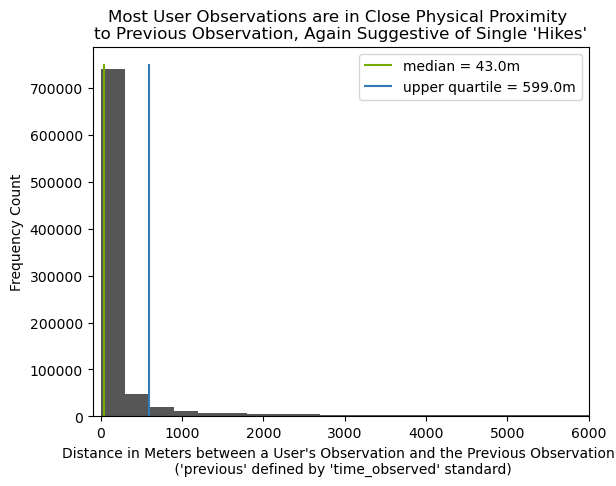

In [20]:
#cutting off visual data after 6 km to see the most important parts of the shape rather than long tail
meters_diff_visual = df_sp[(df_sp["km_diff"]<6) & (df_sp['km_diff']>=0)]["km_diff"]*1000

# median and upper quartile to include in visual
median = round(meters_diff_for_analysis.median(),0)
upper_quartile = round(meters_diff_for_analysis.describe()[6],0)

plt.figure()
plt.hist(meters_diff_visual, color = '#565656', bins = 20)
plt.vlines(median, 0, 750000, color ='#74ac00', label = f'median = {median}m')
plt.vlines(upper_quartile, 0, 750000, color = '#337AB7', label = f'upper quartile = {upper_quartile}m')
plt.legend()
plt.xlim(xmin = -100, xmax = 6000)
plt.xlabel("Distance in Meters between a User's Observation and the Previous Observation \n ('previous' defined by 'time_observed' standard)")
plt.ylabel("Frequency Count")
plt.title("Most User Observations are in Close Physical Proximity \nto Previous Observation, Again Suggestive of Single 'Hikes'")
plt.show()

In [21]:
#How many plant observations in this set are considered needing conservation protection?
num_taxon_obscured_plants = ((df_sp["taxon_kingdom_name"] == "Plantae") \
      & (df_sp["taxon_geoprivacy_obscured"] == 1)).sum()
percent = round(100*num_taxon_obscured_plants/df_sp.shape[0],2)

print(f'{num_taxon_obscured_plants} \
plant observations are marked as having an obscured taxon geoprivacy, \
which is {percent}% of this dataset.')

10421 plant observations are marked as having an obscured taxon geoprivacy, which is 0.99% of this dataset.


# Basic Linear Interpolation Toward Target Species

In [22]:
# indices of rows for target species
target_index = df_sp[(df_sp["taxon_species_name"] == "Lobelia spicata") \
                     & (df_sp["public_positional_accuracy"] <= 30)].index

In [23]:
# storing lat/lon for target species for later validation
validation_dict = {}
for ind in target_index:
    validation_dict[ind] = (df_sp.loc[ind, "latitude"], df_sp.loc[ind, "longitude"])

Using scikit learn's [haversine function ](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.haversine_distances.html) to approximate distance between two lat/lon points.

In [24]:
from sklearn.metrics.pairwise import haversine_distances
from math import radians
def dist_in_meters(lat1, lon1, lat2, lon2): 
    '''
    Takes the latitude and longitude of two different locations 
    and returns the approximate distance in meters between the two.
    
    Arguments:
    lat1 = latitude of first location
    lon1 = longitude of first location
    lat2 = latitude of 2nd location
    lon2 = longitude of 2nd location
   
    Returns: 
    Estimated distance in m between the two lat/lon locations 
    
    '''
    location1 = [lat1, lon1] # locations to lists
    location2 = [lat2, lon2]
    loc1_rad = [radians(deg) for deg in location1] #locations to radians
    loc2_rad = [radians(deg) for deg in location2]
    result = haversine_distances([loc1_rad, loc2_rad]) #haversine distance
    dist = result[0][1] * 6371000  # multiply by Earth radius in m to get m
    return dist

### Question: 
How many datapoints surrounding a target observation is best for predicting its location?

In [25]:

# creates list of columns for interpolation df
columns_for_interpolation = ["latitude", "longitude", "min_from_target"]
# num of target observations
entries = len(target_index) 
# how far above and below the target observation we'll go
num_above_and_below = 25
#data frame for storing best accuracy model
summary_df= pd.DataFrame(index = range(entries), columns=["original_index", "best_num_datapoints", "best_lat", "best_lon", "best_dist"])

for i in range(entries): #for future: this code is inefficient and should just run through for ind in target index
    # target and surrounding info
    min_row = target_index[i] - num_above_and_below
    if min_row <= 0: # avoids any data points that don't have 25 below
        continue
    max_row = target_index[i] + num_above_and_below
    if max_row >= df_sp.shape[0]: # avoids any data points that don't have 25 above
        continue
    target_time = df_sp.loc[target_index[i], "time_observed_at"]
    best_stats = {'best_num': 0, 'best_lat': 0, 'best_lon': 0, 'best_dist': 100}
    
    # subset of entries around target, with relevant columns,
    # a new column for minutes away from target and reindexed
    subset = df_sp.loc[min_row:max_row, ("id", "latitude", "longitude", "time_observed_at")] # chosen rows and columns
    subset["min_from_target"] = 0 # new column for minutes away from target
    for j in range(min_row, max_row + 1):
        min_away = (subset.loc[j, "time_observed_at"] - target_time).total_seconds() / 60
        subset.loc[j, "min_from_target"] = min_away
    
    subset.drop(target_index[i], inplace = True) #dropping target and resetting index
    subset.reset_index(inplace = True)
    
# creates list of indices above and below target value given number of datapoints we want above 
# with presumption of number of above = number below
# builds loop where only two rows grabbed for interpolation, then 4, then 6...
    best_dist = np.inf # for use later in best accuracy for each target observation
    desired_indices = [] 
    for num in range(num_above_and_below):
        desired_indices.append(num_above_and_below - 1 - num)
        desired_indices.append(num_above_and_below + num)
        
# creates dataframe for only the chosen rows surrounding the target
        lin_reg_df = subset.loc[desired_indices, columns_for_interpolation]  

# creates independent columns with constant for lin reg analysis
        X_withconstant = sm.add_constant(lin_reg_df["min_from_target"])

# creates dependent columns for latitude and longitude
        yLAT = lin_reg_df["latitude"]
        yLON = lin_reg_df["longitude"]

# instantiates and fits one OLS for dependent of latitude and another for longitude
        lin_reg_resultsLAT = sm.OLS(yLAT, X_withconstant).fit()
        lin_reg_resultsLON = sm.OLS(yLON, X_withconstant).fit() 

# calculates how far prediction is from actual
        meters_from_actual = dist_in_meters(lin_reg_resultsLAT.params[0], lin_reg_resultsLON.params[0], validation_dict[target_index[i]][0], validation_dict[target_index[i]][1])
# stores relevant info for best model in dataframe
        summary_df.loc[i,"original_index"] = target_index[i]
        if meters_from_actual < best_dist:
            best_dist = meters_from_actual
            summary_df.loc[i,"best_dist"] = meters_from_actual
            summary_df.loc[i,"best_num_datapoints"] = (num + 1)*2
            summary_df.loc[i,"best_lat"] = lin_reg_resultsLAT.params[0]
            summary_df.loc[i,"best_lon"] = lin_reg_resultsLON.params[0]

In [26]:
summary_df = summary_df.apply(pd.to_numeric)

In [27]:
round(summary_df.describe(),2)

,original_index,best_num_datapoints,best_lat,best_lon,best_dist
count,505.00,505.00,505.00,505.00,505.00
mean,664967.23,5.59,39.46,-86.34,5132.53
std,314974.88,9.07,3.66,6.73,45276.07
min,12508.00,2.00,29.56,-96.47,0.00
25%,469274.00,2.00,36.22,-91.50,7.36
50%,766485.00,2.00,40.02,-87.86,25.07
75%,917558.00,4.00,42.14,-83.16,166.92
max,1050047.00,50.00,48.68,-62.68,814604.74


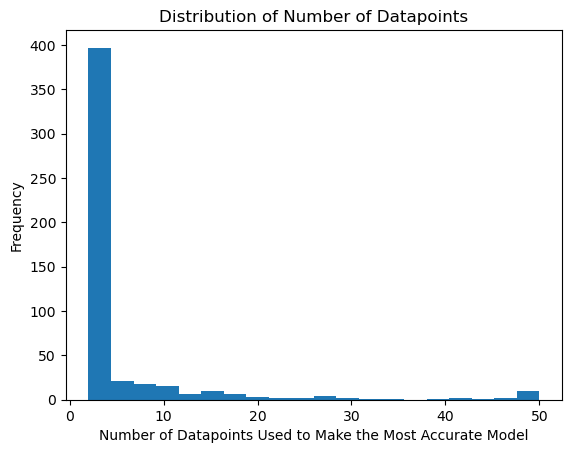

In [28]:
plt.figure()
plt.hist(summary_df["best_num_datapoints"], bins = 20)
plt.xlabel("Number of Datapoints Used to Make the Most Accurate Model")
plt.ylabel("Frequency")
plt.title("Distribution of Number of Datapoints")
plt.show()

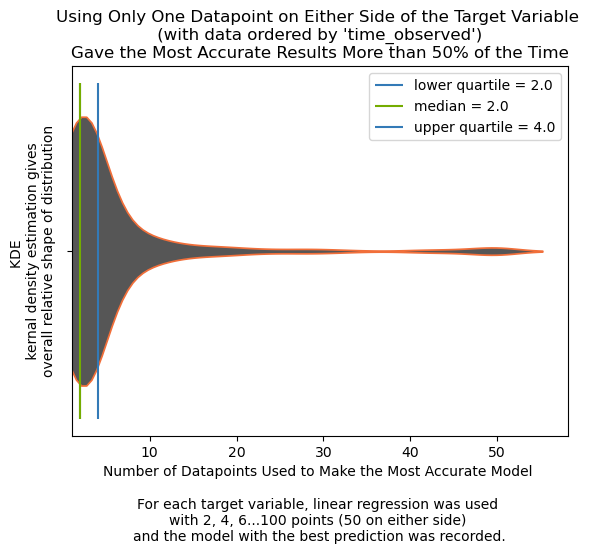

In [29]:
#Violin plot of distribution of datapoints--choosing this because histogram is so choppy
# and I also just want the general shape
# But also, I'll admit I think they are nice looking and kinda just want to have use one for once

# quartiles for plotting as vertical line
lower_quartile = summary_df["best_num_datapoints"].describe()[4]
median = summary_df["best_num_datapoints"].describe()[5]
upper_quartile = summary_df["best_num_datapoints"].describe()[6]

plt.figure()
sns.violinplot(x = summary_df["best_num_datapoints"], color = '#565656', inner = None, linecolor = '#f16f3a')
plt.xlabel("Number of Datapoints Used to Make the Most Accurate Model \n \nFor each target variable, linear regression was used \nwith 2, 4, 6...100 points (50 on either side) \nand the model with the best prediction was recorded.")
plt.ylabel("KDE \n kernal density estimation gives \noverall relative shape of distribution")
plt.title("Using Only One Datapoint on Either Side of the Target Variable \n (with data ordered by 'time_observed') \nGave the Most Accurate Results More than 50% of the Time")

plt.vlines(lower_quartile, -0.5, 0.5, color = '#337AB7', label = f'lower quartile = {lower_quartile}')
plt.vlines(median, -0.5, 0.5, color = '#74ac00', label = f'median = {median}')
plt.vlines(upper_quartile, -0.5, 0.5, color = '#337AB7', label = f'upper quartile = {upper_quartile}')

plt.xlim(xmin = 1) # 2 is actually the min value but would like to see the median line plotted
plt.legend()
plt.show()

### Question: 
Using only one datapoint on either side of the target, how well does linear interpolation predict location?

In [30]:

# creating empty dataframe for storing results
entries = len(target_index) 
new_summary_df= pd.DataFrame(index = range(entries), columns=["original_index", "lat_pred", "lon_pred", "dist_from_target"])
i = 0

#looping through each target variable
for ind in target_index:
    # necessary info for linear interpolation
    target_time = df_sp.loc[ind, "time_observed_at"]
    time_before = df_sp.loc[ind - 1, "time_observed_at"]
    lat_before = df_sp.loc[ind - 1, "latitude"]
    lon_before = df_sp.loc[ind - 1, "longitude"]
    time_after = df_sp.loc[ind + 1, "time_observed_at"]
    lat_after = df_sp.loc[ind + 1, "latitude"]
    lon_after = df_sp.loc[ind + 1, "longitude"]
    
    # simple linear interpolation between two points
    if time_after != time_before: 
        predicted_lat = (lat_after - lat_before) * (target_time - time_before) / (time_after - time_before) + lat_before
        predicted_lon = (lon_after - lon_before) * (target_time - time_before) / (time_after - time_before) + lon_before
    else: #if time before is equal to time after, assumption is that location has not changed (could check and take average instead)
        predicted_lat = lat_before
        predicted_lon = lon_before
    

# calculates how far prediction is from actual
    meters_from_actual = dist_in_meters(predicted_lat, predicted_lon, validation_dict[ind][0], validation_dict[ind][1])
# stores summary info in summary dataframe for each target location   
    new_summary_df.loc[i,"original_index"] = ind
    new_summary_df.loc[i,"dist_from_target"] = meters_from_actual
    new_summary_df.loc[i,"lat_pred"] = predicted_lat
    new_summary_df.loc[i,"lon_pred"] = predicted_lon
    i += 1

In [31]:
new_summary_df = new_summary_df.apply(pd.to_numeric)
new_summary_df.describe()

,original_index,lat_pred,lon_pred,dist_from_target
count,5.070000e+02,507.000000,507.000000,5.070000e+02
mean,6.664867e+05,39.459691,-85.993882,3.151677e+04
std,3.152795e+05,3.662454,9.848362,4.686679e+05
min,1.250800e+04,29.562950,-97.814546,0.000000e+00
25%,4.692750e+05,36.230711,-91.540751,8.296683e+00
50%,7.670850e+05,40.019482,-87.861163,3.306339e+01
75%,9.178490e+05,42.139730,-83.143951,2.518986e+02
max,1.050149e+06,48.677715,68.688940,9.827748e+06


In [32]:
new_summary_df[new_summary_df["dist_from_target"]<=76].shape[0] * 100 / new_summary_df.shape[0]

64.1025641025641

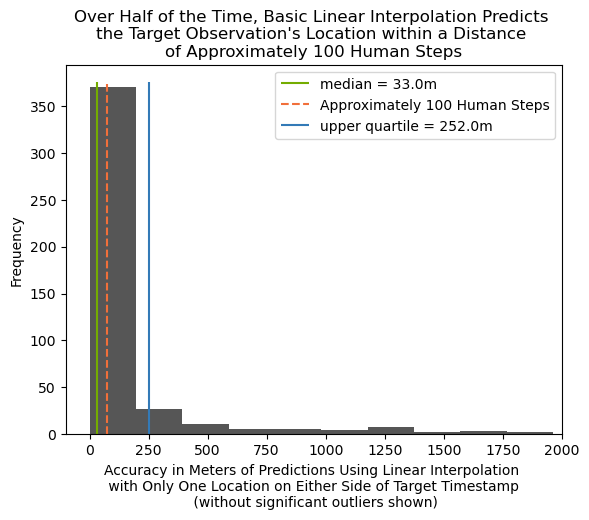

In [33]:
# What is the distribution of accuracy? (Had to limit visual to 2K or less due to outliers)

#quartiles for plotting vertical lines
median = round(new_summary_df["dist_from_target"].describe()[5],0)
upper_quartile = round(new_summary_df["dist_from_target"].describe()[6],0)

plt.figure()
plt.hist(new_summary_df[new_summary_df["dist_from_target"]<=2000]["dist_from_target"], color = '#565656')
plt.xlabel("Accuracy in Meters of Predictions Using Linear Interpolation \n with Only One Location on Either Side of Target Timestamp \n (without significant outliers shown)")
plt.ylabel("Frequency")
plt.title("Over Half of the Time, Basic Linear Interpolation Predicts \nthe Target Observation's Location within a Distance \nof Approximately 100 Human Steps")

plt.vlines(median, 0, 375, color = '#74ac00', label = f'median = {median}m')
# 76 m is approximately 100 human steps
plt.vlines(76, 0, 375, color = '#f16f3a' , label = "Approximately 100 Human Steps", linestyle = "dashed")
plt.vlines(upper_quartile, 0, 375, color = '#337AB7', label = f'upper quartile = {upper_quartile}m')

plt.xlim(xmin = -100, xmax = 2000)
plt.legend()
plt.show()
